In [1]:
# Try to decode which feature was selected per-trial based on firing rates of neurons
# experiment with ranges of firing rates around fixation (selection) time

%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as patches
import pandas as pd
import scipy.stats
from lfp_tools import (
    general as lfp_general,
    startup as lfp_startup,
    development as lfp_development,
    analysis as lfp_analysis
)
from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)
import s3fs
import utils.behavioral_utils as behavioral_utils
import utils.spike_utils as spike_utils
import utils.classifier_utils as classifier_utils
import utils.visualization_utils as visualization_utils
import utils.io_utils as io_utils
from trial_splitters.random_splitter import RandomSplitter
from trial_splitters.block_splitter import BlockSplitter
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
import pickle

from models.value_models import ValueLinearModel, ValueNormedModel
from models.multinomial_logistic_regressor import MultinomialLogisticRegressor, NormedMultinomialLogisticRegressor
from models.model_wrapper import ModelWrapper

from models.trainer import Trainer

import torch

import plotly.express as px

matplotlib.rcParams['figure.dpi'] = 300
from itertools import accumulate

species = 'nhp'
subject = 'SA'
exp = 'WCST'
session = 20180802  # this is the session for which there are spikes at the moment. 

feature_dims = ["Color", "Shape", "Pattern"]

pre_interval = 1300
post_interval = 1500


In [2]:
# grab behavioral data, spike data, trial numbers. 
fs = s3fs.S3FileSystem()
behavior_file = spike_general.get_behavior_path(subject, session)
behavior_data = pd.read_csv(fs.open(behavior_file))
valid_beh = behavior_data[behavior_data.Response.isin(["Correct", "Incorrect"])]   
shuffled_card_idxs = behavioral_utils.get_shuffled_card_idxs(valid_beh)

### Find clusters of units

In [3]:
models = np.load(fs.open(f"l2l.pqz317.scratch/value_normed_model_models_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy"), allow_pickle=True)
weights = classifier_utils.evaluate_model_weights_by_time_bins(models, 59, 12)

In [4]:
weights_clusters = KMeans(n_clusters=5, random_state=0).fit_predict(weights)

In [5]:
weights_clusters

array([4, 4, 2, 0, 0, 4, 4, 0, 2, 1, 0, 0, 0, 4, 3, 4, 0, 0, 2, 4, 0, 4,
       0, 4, 4, 0, 0, 0, 0, 0, 2, 1, 4, 2, 4, 0, 2, 0, 1, 0, 0, 4, 4, 4,
       0, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 0, 0, 4], dtype=int32)

In [6]:
np.unique(weights_clusters, return_counts=True)

(array([0, 1, 2, 3, 4], dtype=int32), array([23,  3,  6,  1, 26]))

In [7]:
weights_df = classifier_utils.convert_model_weights_to_df(weights, -1300, 100)

units = spike_general.list_session_units(fs, subject, session)
electrode_pos = lfp_development.get_electrode_xyz(fs, "nhp", subject, "WCST", str(session), chans_spc="all")

unit_pos = pd.merge(units, electrode_pos, left_on="Channel", right_on="ch", how="left")
unit_pos = unit_pos.astype({"UnitID": int})
unit_pos["WeightsCluster"] = weights_clusters[unit_pos.UnitID].astype(str)

59


In [8]:
np_pos = unit_pos[['x', 'y', 'z']].to_numpy()
spatial_clusters = KMeans(n_clusters=5, random_state=0).fit_predict(np_pos)


In [9]:
np.unique(spatial_clusters, return_counts=True)

(array([0, 1, 2, 3, 4], dtype=int32), array([12, 23,  9,  4, 11]))

In [10]:
name_to_color = {
    "fef": '#3366CC', 
    "hippocampus" : '#DC3912', 
    "lpfc": '#FF9900', 
    "parietal": '#109618', 
    "mpfc": '#990099'
}

unit_pos["SpatialCluster"] = spatial_clusters[unit_pos.UnitID]
spatial_cluster_mapping = np.array(["fef", "hippocampus", "lpfc", "parietal", "mpfc"])
unit_pos["SpatialClusterName"] = spatial_cluster_mapping[unit_pos["SpatialCluster"]]

In [15]:
fig1 = px.scatter_3d(
    unit_pos, x="x", y="y", z="z", 
    color="SpatialClusterName", 
    labels={"SpatialClusterName": "Unit Location"},
    color_discrete_map=name_to_color)
fig = visualization_utils.plotly_add_glass_brain(fs, fig1, subject, areas='all', show_axis=False)
fig.update_layout(
    autosize=False,
    width=700,
    height=700,
)
fig.update_layout(legend=dict(
    yanchor="top",
    y=0.6,
    xanchor="left",
    x=0.9,
))
fig.write_html("../data/weights_pos_spatial_clusters_legend_anchor.html")

In [12]:

fig1 = px.scatter_3d(unit_pos, x="x", y="y", z="z", color="WeightsCluster", color_discrete_sequence=px.colors.qualitative.G10)
fig = visualization_utils.plotly_add_glass_brain(fs, fig1, subject, areas='all', show_axis=False)
fig.update_layout(
    autosize=False,
    width=700,
    height=700,
)
fig.write_html("../data/weights_pos_weights_clusters.html")

In [17]:
mpfc = np.argwhere(spatial_clusters == 4)
lpfc = np.argwhere(spatial_clusters == 2)
fef = np.argwhere(spatial_clusters == 0)
hipp = np.argwhere(spatial_clusters == 1)
parietal = np.argwhere(spatial_clusters == 3)

reordered_units = np.squeeze(np.concatenate((mpfc, lpfc, fef, parietal, hipp)))

In [18]:
reg_names = ["mpfc", "lpfc", "fef", "parietal", "hipp"]
regs = [mpfc, lpfc, fef, parietal, hipp]
lens = [len(reg) for reg in regs]
lens_accum = list(accumulate(lens))
reg_start = lens_accum[:-1].insert(0, 0)
reg_end = list(np.array(lens_accum[1:]) - 1)
lines = np.array(lens_accum[0:-1]) - 0.5

[10.5 19.5 31.5 35.5]
6


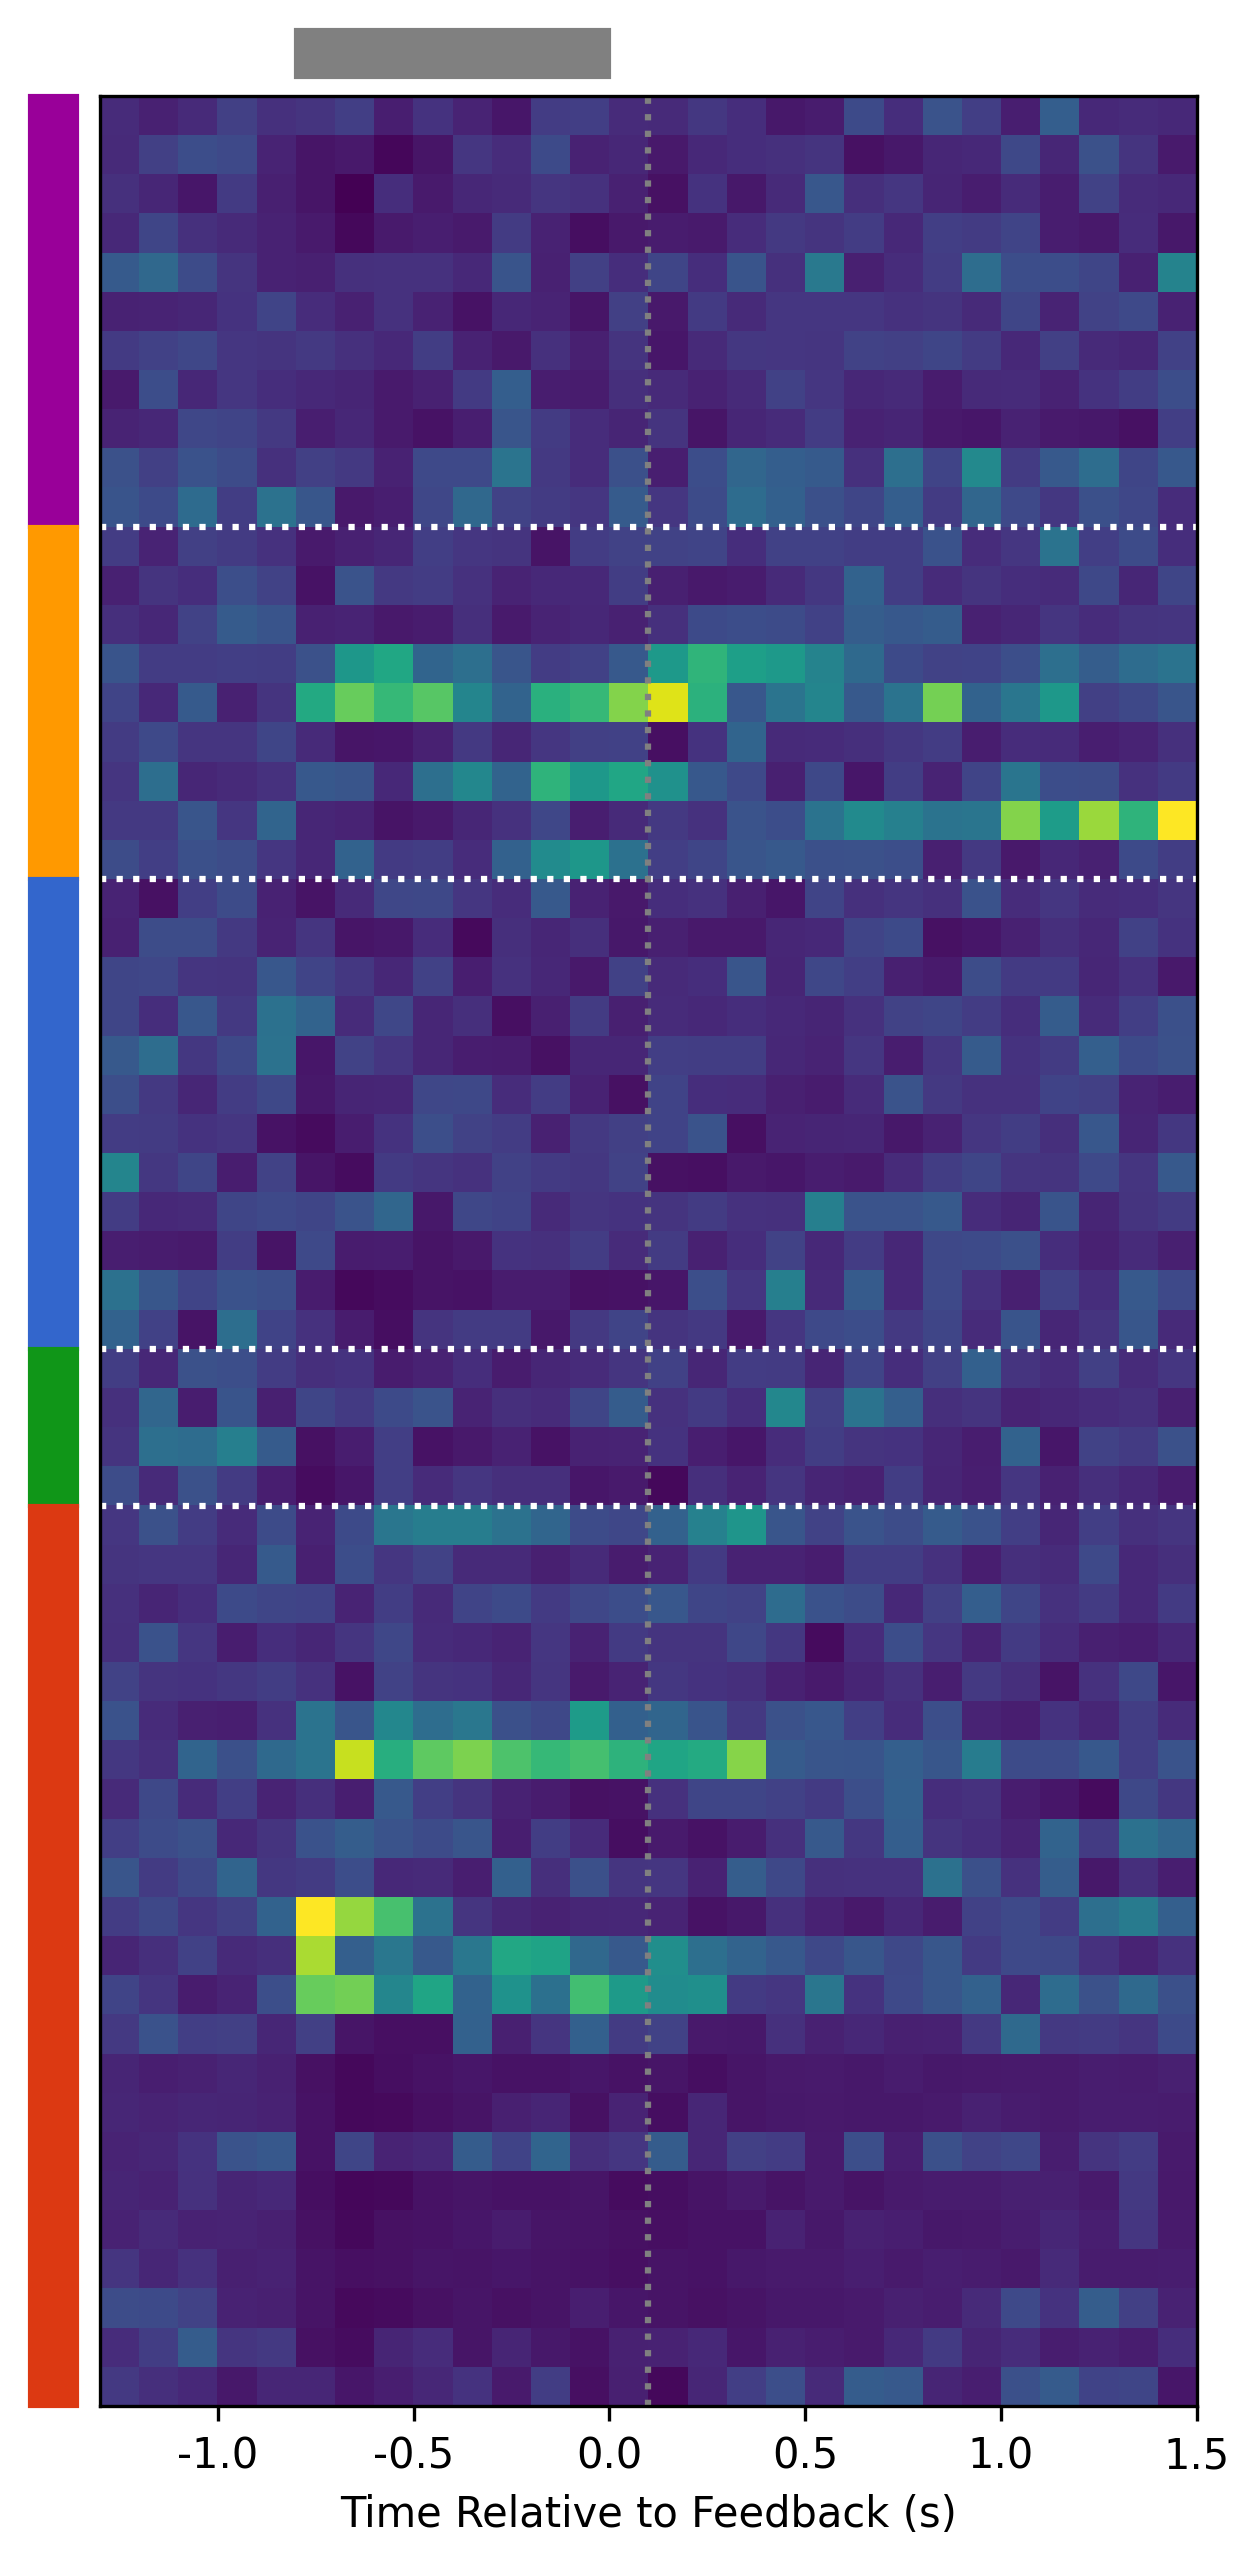

In [19]:
name_to_color = {
    "fef": '#3366CC', 
    "hippocampus" : '#DC3912', 
    "lpfc": '#FF9900', 
    "parietal": '#109618', 
    "mpfc": '#990099'
}
colormap = ["#990099", "#FF9900", "#3366CC", "#109618", "#DC3912"]
# models are num_time_points x num_models
pre_interval = 1300
post_interval = 1500
models = np.load(fs.open(f"l2l.pqz317.scratch/value_normed_model_models_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy"), allow_pickle=True)
weights = classifier_utils.evaluate_model_weights_by_time_bins(models, 59, 12)

sums = np.sum(weights, axis=0)

normalized = weights / sums

# reorder by temp then ant
reordered = normalized[reordered_units, :]



fig, ax = plt.subplots(figsize=(20, 10))
colors = ax.matshow(reordered)
# tick_labels = np.array([-1.2, -0.9, -0.6, -0.3, 0, 0.3, 0.6, 0.9, 1.2])
tick_labels = np.array([-1, -0.5, 0, 0.5, 1.0, 1.5])
tick_pos = (tick_labels + 1.3) * 10 - 0.5
# fig.colorbar(colors)
# axis = np.arange(0, 28, 3)
# labels = np.around((axis - 13) * 0.1, 1)
ax.set_xticks(tick_pos)
ax.set_xticklabels(tick_labels)
ax.xaxis.tick_bottom()
ax.set_xlabel("Time Relative to Feedback (s)")
ax.get_yaxis().set_visible(False)
ax.set_ylabel([])
# y_axis = np.arange(0, 59, 5)
# ax.set_yticks(y_axis)
# ax.set_yticklabels(y_axis)

boundaries = np.insert(np.insert(lines, len(lines), reordered.shape[0] - 0.5), 0, -0.5)
print(lines)
print(len(boundaries))
for line in lines:
    ax.axhline(line, color='white', linestyle="dotted")

for i in range(len(boundaries)-1):
    rect = patches.Rectangle(
        (
            -1.3 - 1,
            (boundaries[i])#+boundaries[i+1]) / 2
        ),
        1.2,
        (boundaries[i+1]-boundaries[i]),
        edgecolor=colormap[i],
        facecolor=colormap[i],
        clip_on=False
    )
    ax.add_patch(rect)
gray_rect = patches.Rectangle(
    (4.5, -2.2), 8, 1.2,
    edgecolor="gray",
    facecolor="gray",
    clip_on=False,
)
ax.add_patch(gray_rect)
ax.axvline(13.48, color="gray", linestyle="dotted")

